In [2]:
import pandas as pd
import numpy as np

# Plotting and correlation
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

Goal: generate future vehicle distributions based on current trends

**Load data**

In [3]:
fuel_types = ['electric','plug-in hybrid electric','fuel cell','diesel','flex fuel','gasoline','gasoline hybrid','natural gas fuel','propane']

# CA monthly light-duty vehicle registrations by fuel type

df = pd.read_csv('data/cleaned/monthly_vehicles.csv')
df = df.drop(columns=['Unnamed: 0'])

print(f"shape: {df.shape}")
df.head()

shape: (132, 12)


,date,electric,plug-in hybrid electric,fuel cell,diesel,flex fuel,gasoline,gasoline hybrid,natural gas fuel,propane,total,date_idx
0,202112,522445,305315,10127,590216,1208970,25998618,1298275,8461,90,29942517,132
1,202111,505951,300973,9877,599395,1203600,25917181,1285769,8395,157,29836132,131
2,202110,490400,297256,9627,608574,1198231,25835745,1275167,8330,224,29729751,130
3,202109,476248,292462,9377,617753,1192861,25754308,1263823,8264,291,29623366,129
4,202108,462251,289169,9127,626932,1187492,25672872,1253083,8199,359,29516987,128


**Polynomial regression**

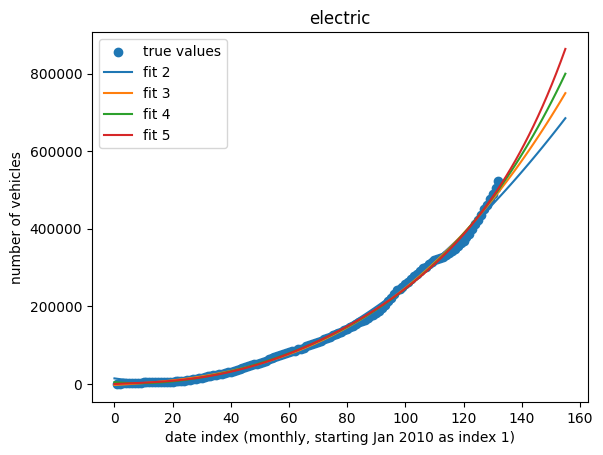

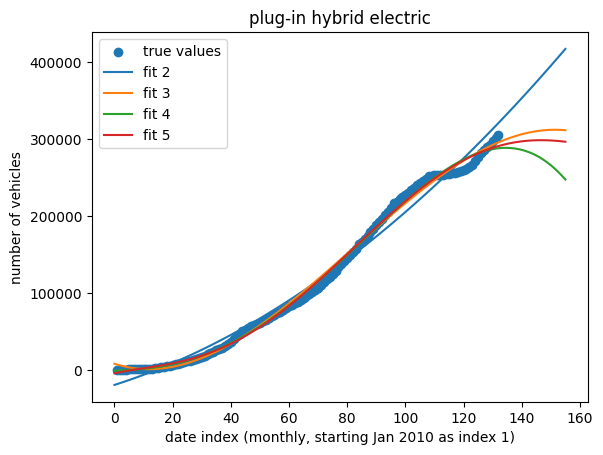

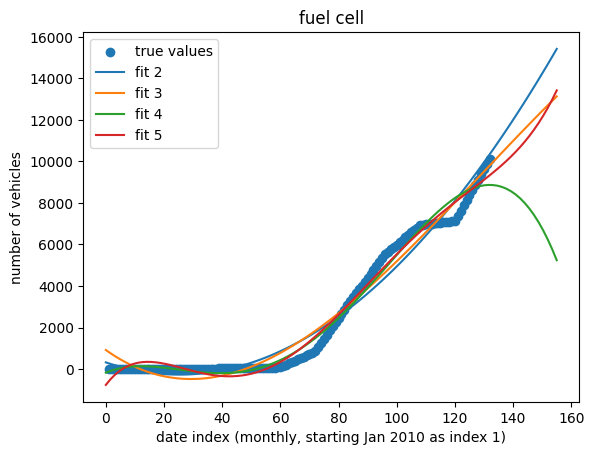

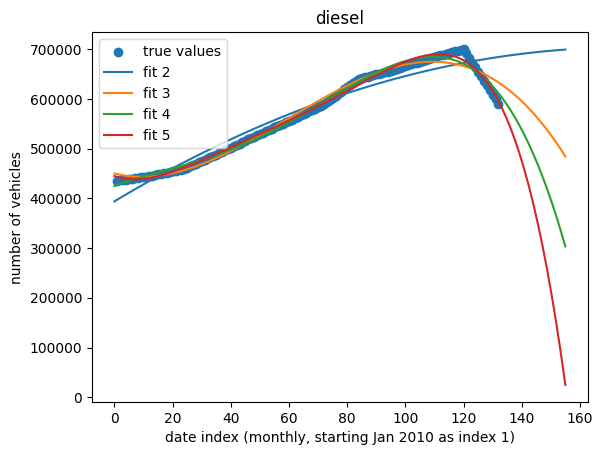

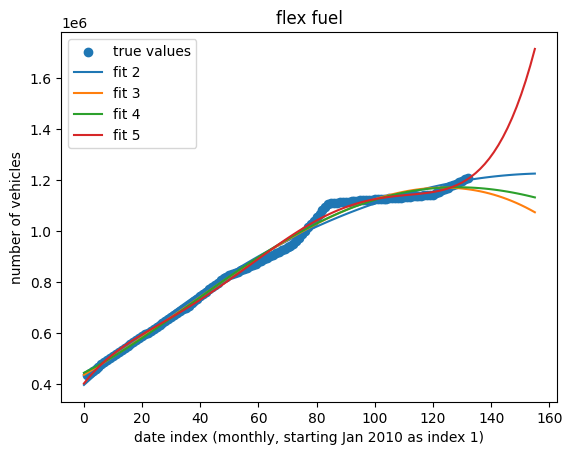

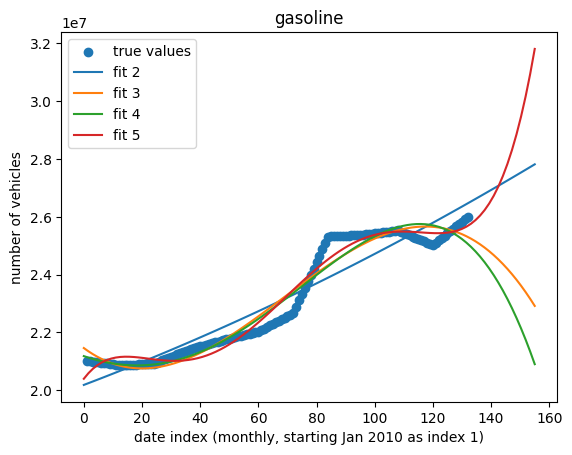

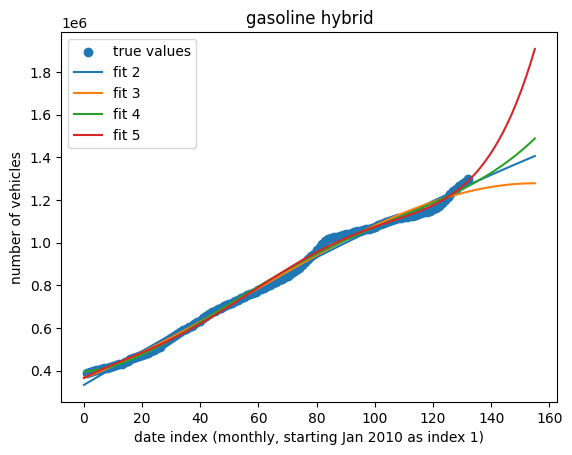

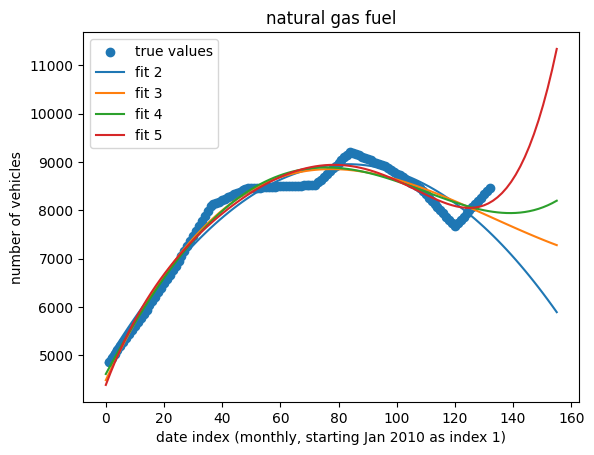

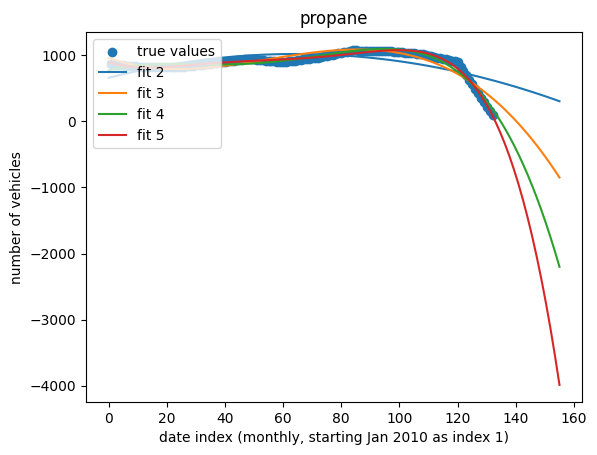

In [7]:
# for each vehicle type, show different possible growth projections

X = df['date_idx']
for fuel in fuel_types:
    y = df[fuel]

    poly_model = np.poly1d(np.polyfit(X, y, 2))
    poly_line = np.linspace(0, 155, 100)

    poly_model3 = np.poly1d(np.polyfit(X, y, 3))
    poly_line3 = np.linspace(0, 155, 100)

    poly_model4 = np.poly1d(np.polyfit(X, y, 4))
    poly_line4 = np.linspace(0, 155, 100)
    
    poly_model5 = np.poly1d(np.polyfit(X, y, 5))
    poly_line5 = np.linspace(0, 155, 100)
    
    # poly_model6 = np.poly1d(np.polyfit(X, y, 6))
    # poly_line6 = np.linspace(0, 155, 100)

    plt.scatter(X, y)
    plt.plot(poly_line, poly_model(poly_line))
    plt.plot(poly_line3, poly_model3(poly_line3))
    plt.plot(poly_line4, poly_model4(poly_line4))
    plt.plot(poly_line5, poly_model5(poly_line5))
    # plt.plot(poly_line6, poly_model6(poly_line6))
    plt.title(fuel)
    plt.legend(['true values','fit 2','fit 3','fit 4','fit 5','fit 6'],loc='upper left')
    plt.xlabel('date index (monthly, starting Jan 2010 as index 1)')
    plt.ylabel('number of vehicles')
    plt.show()

We are generating example data, but want it to be somewhat "realistic," so we use our best judgment based on our understanding of vehicle popularity and past trends to decide which pattern seems most plausible

**Example case**

In [40]:
# given date of YEARMONTH format, get date_idx

NUM_MONTHS = 12
FIRST_YEAR = 2014

def to_index(date):
    date_year = int(str(date)[0:4])
    if date_year < 2014:
        print('Date must be 2014 or later')
    date_month = int(str(date)[4:6])
    if date_month < 0 or date_month > NUM_MONTHS:
        print('Invalid month')
    months_to_curr_year = (date_year - FIRST_YEAR) * NUM_MONTHS
    date_idx = months_to_curr_year + date_month - 1
    return date_year, date_month, date_idx 


In [43]:
# given date of YEARMONTH format and which fits to use for each vehicle type, predict vehicle distribution

def predict_distribution(date, fit_list):
    year, month, test_date_idx = to_index(date)

    print(f'In month {month} of {year} or date index {test_date_idx}, we predict:')

    vehicle_nums = {}
    for fuel in fuel_types:
        y = df[fuel]
        fit = fit_list[fuel]
        poly_model = np.poly1d(np.polyfit(X, y, fit))
        predicted_vehicles = int(poly_model(test_date_idx))
        if predicted_vehicles < 0:
            predicted_vehicles = 0
        vehicle_nums[fuel] = predicted_vehicles

    total_vehicles = sum(list(vehicle_nums.values()))
    print(f'Total vehicles: {total_vehicles}')
    for vehicle in vehicle_nums:
        num_vehicles = vehicle_nums[vehicle]
        percentage = round(num_vehicles/total_vehicles * 100, 2)
        print(f'Estimated number of {vehicle} vehicles: {num_vehicles} or {percentage}%')
    
    # plot predictions relative to past data
    # orange point is prediction
    for fuel in fuel_types:
        plt.scatter(df['date_idx'],df[fuel])
        plt.scatter(test_date_idx,vehicle_nums[fuel])
        plt.title(fuel)
        plt.show()

    return test_date_idx, vehicle_nums

In month 8 of 2026 or date index 151, we predict:
Total vehicles: 31489867
Estimated number of electric vehicles: 699835 or 2.22%
Estimated number of plug-in hybrid electric vehicles: 312033 or 0.99%
Estimated number of fuel cell vehicles: 12573 or 0.04%
Estimated number of diesel vehicles: 379989 or 1.21%
Estimated number of flex fuel vehicles: 1224642 or 3.89%
Estimated number of gasoline vehicles: 27575770 or 87.57%
Estimated number of gasoline hybrid vehicles: 1276945 or 4.06%
Estimated number of natural gas fuel vehicles: 8080 or 0.03%
Estimated number of propane vehicles: 0 or 0.0%


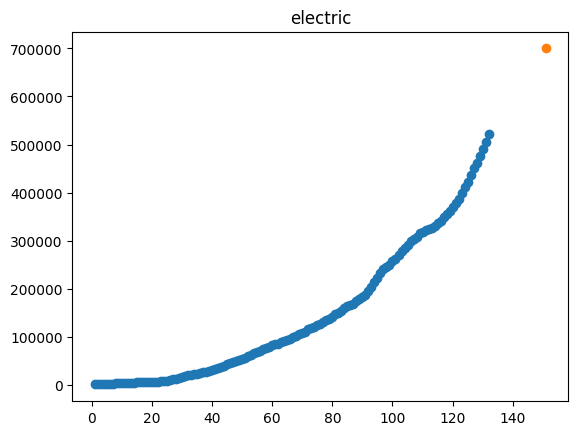

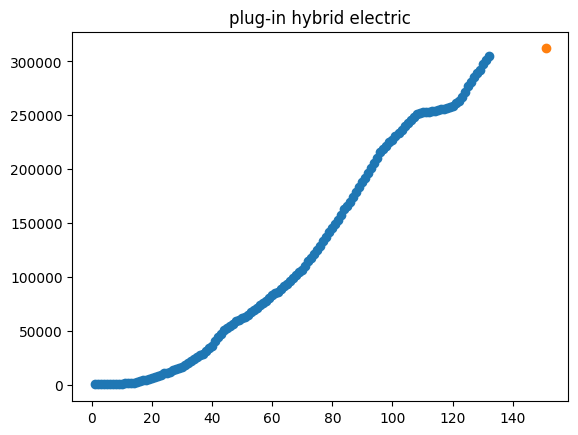

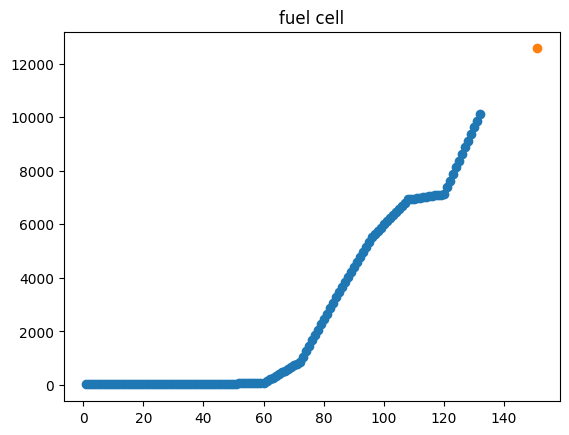

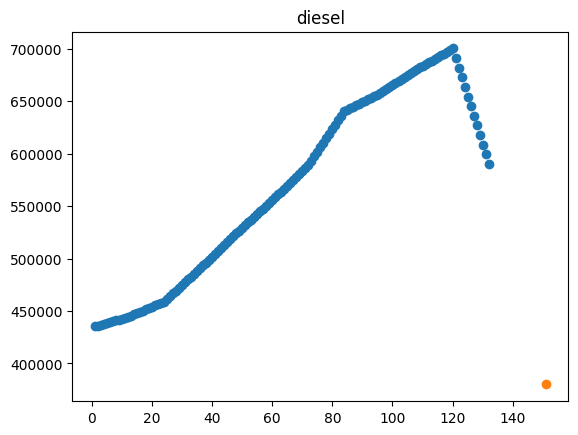

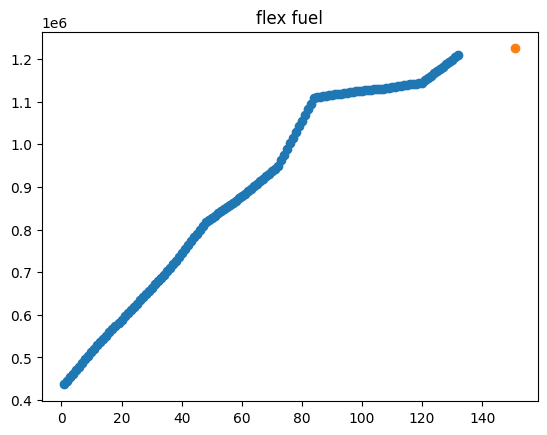

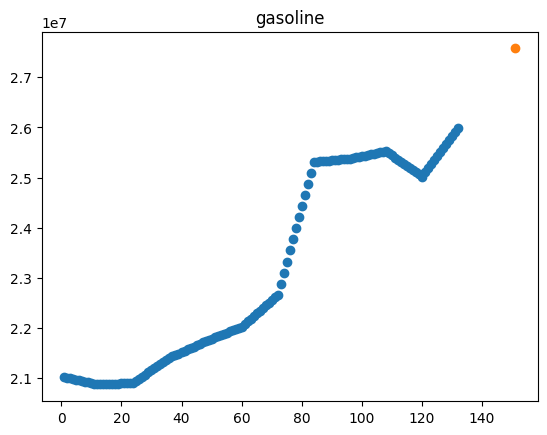

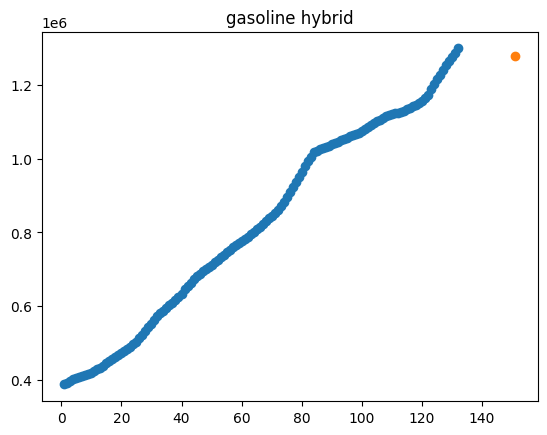

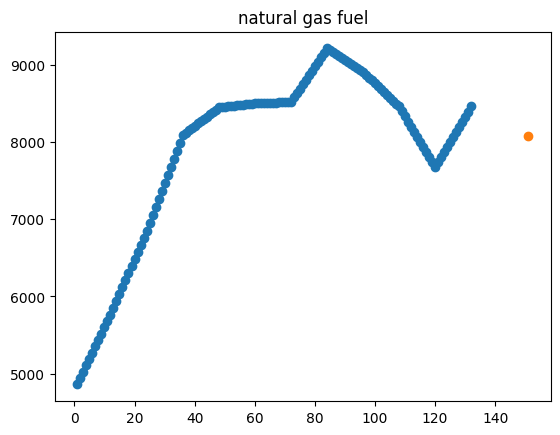

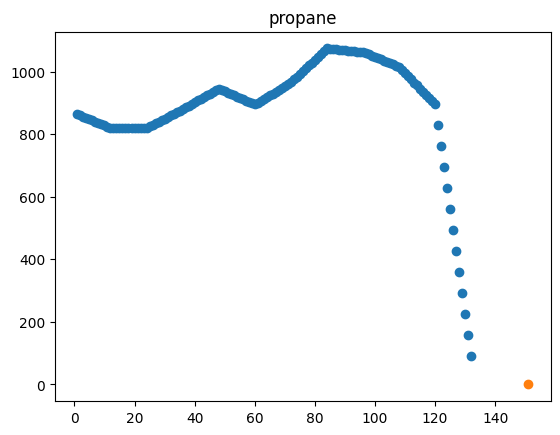

In [44]:
test_date = 202608 # test date, Aug 2026, format YEARMONTH

# how we decided to model each vehicle type's growth
fit_list = {
    'electric': 3, # 2 = least optimistic, 5 = most optimistic
    'plug-in hybrid electric': 3,
    'fuel cell': 3,
    'gasoline hybrid': 3,
    'flex fuel': 2,
    'gasoline': 2,
    'diesel': 4,
    'natural gas fuel': 4,
    'propane': 4
}

test_date_idx, vehicle_nums = predict_distribution(test_date, fit_list)